In [3]:
import mlflow.keras
import mlflow
import mlflow.tensorflow
from sklearn.model_selection import train_test_split, cross_val_score

from table_functions import *
from analyze_visualisation import *
from ml_models.decision_tree import *
from ml_models.random_forest import *
from ml_models.xg_boost import *
from ml_models.neural_network_train import *
from ml_models.extra_random_forest import *

In [4]:
# TO MUSI BYC USTAWIONE ZAWSZE TAK SAMO, a potem jak sie chce umieszczac dane modele w innym folderze to zmienia sie nazwe  artifact_directory = "other_classification"
# jak chce sie wlaczyc potem mlflow w przegladarce, trzeba w terminalu przejsc do lokalizacji 'src' i wpisac komende mlflow ui
ml_runs_directory = r"C:\Users\dlxpq69\Desktop\Projekt_AI\meb_process_data_analysis\src\mlruns"
mlflow.set_tracking_uri(f"file://{ml_runs_directory}")

In [5]:
data_keys = ['x_train', 'x_valid', 'x_test', 'y_train', 'y_valid', 'y_test']
ml_data = {key: None for key in data_keys}
for key in ml_data:
    ml_data[key] = read_csv(f'{key}.csv')

In [6]:
ml_data_no_cat = ml_data.copy()
categorical_columns_ = list(ml_data_no_cat['x_train'].iloc[:, 130:].columns)
for cold in ['x_train', 'x_valid', 'x_test']:
    ml_data_no_cat[cold].drop(columns=categorical_columns_, inplace=True)

In [ ]:
ml_data_dgm = ml_data.copy()
for cold in ['x_train', 'x_valid', 'x_test']:
    ml_data_dgm[cold] = ml_data_dgm[cold].loc[:, :'czas_taktu']

In [ ]:
final_table = read_csv('final_table_before_normalization.csv')
ml_data_small = split_data(final_table, nok_samples=100000, ok_samples=100000)
ml_data_small['x_train'], scaler = normalize_data(ml_data_small['x_train'])
ml_data_small['x_valid'] = normalize_data(ml_data_small['x_valid'], scaler)
ml_data_small['x_test'] = normalize_data(ml_data_small['x_test'], scaler)

<h4>Drzewo decyzyjne</h4>

In [7]:
def make_decision_tree(clf, max_depth_, feature_names, class_names):
    from sklearn.tree import export_graphviz
    import graphviz

    dot_data = export_graphviz(clf,
                    out_file=None,
                    feature_names=feature_names,
                    class_names=class_names,
                    special_characters=True,
                    rounded=True,
                    filled=True)
    graph = graphviz.Source(dot_data)
    graph.render('graph')

2023/10/13 10:54:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Program Files\Python310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

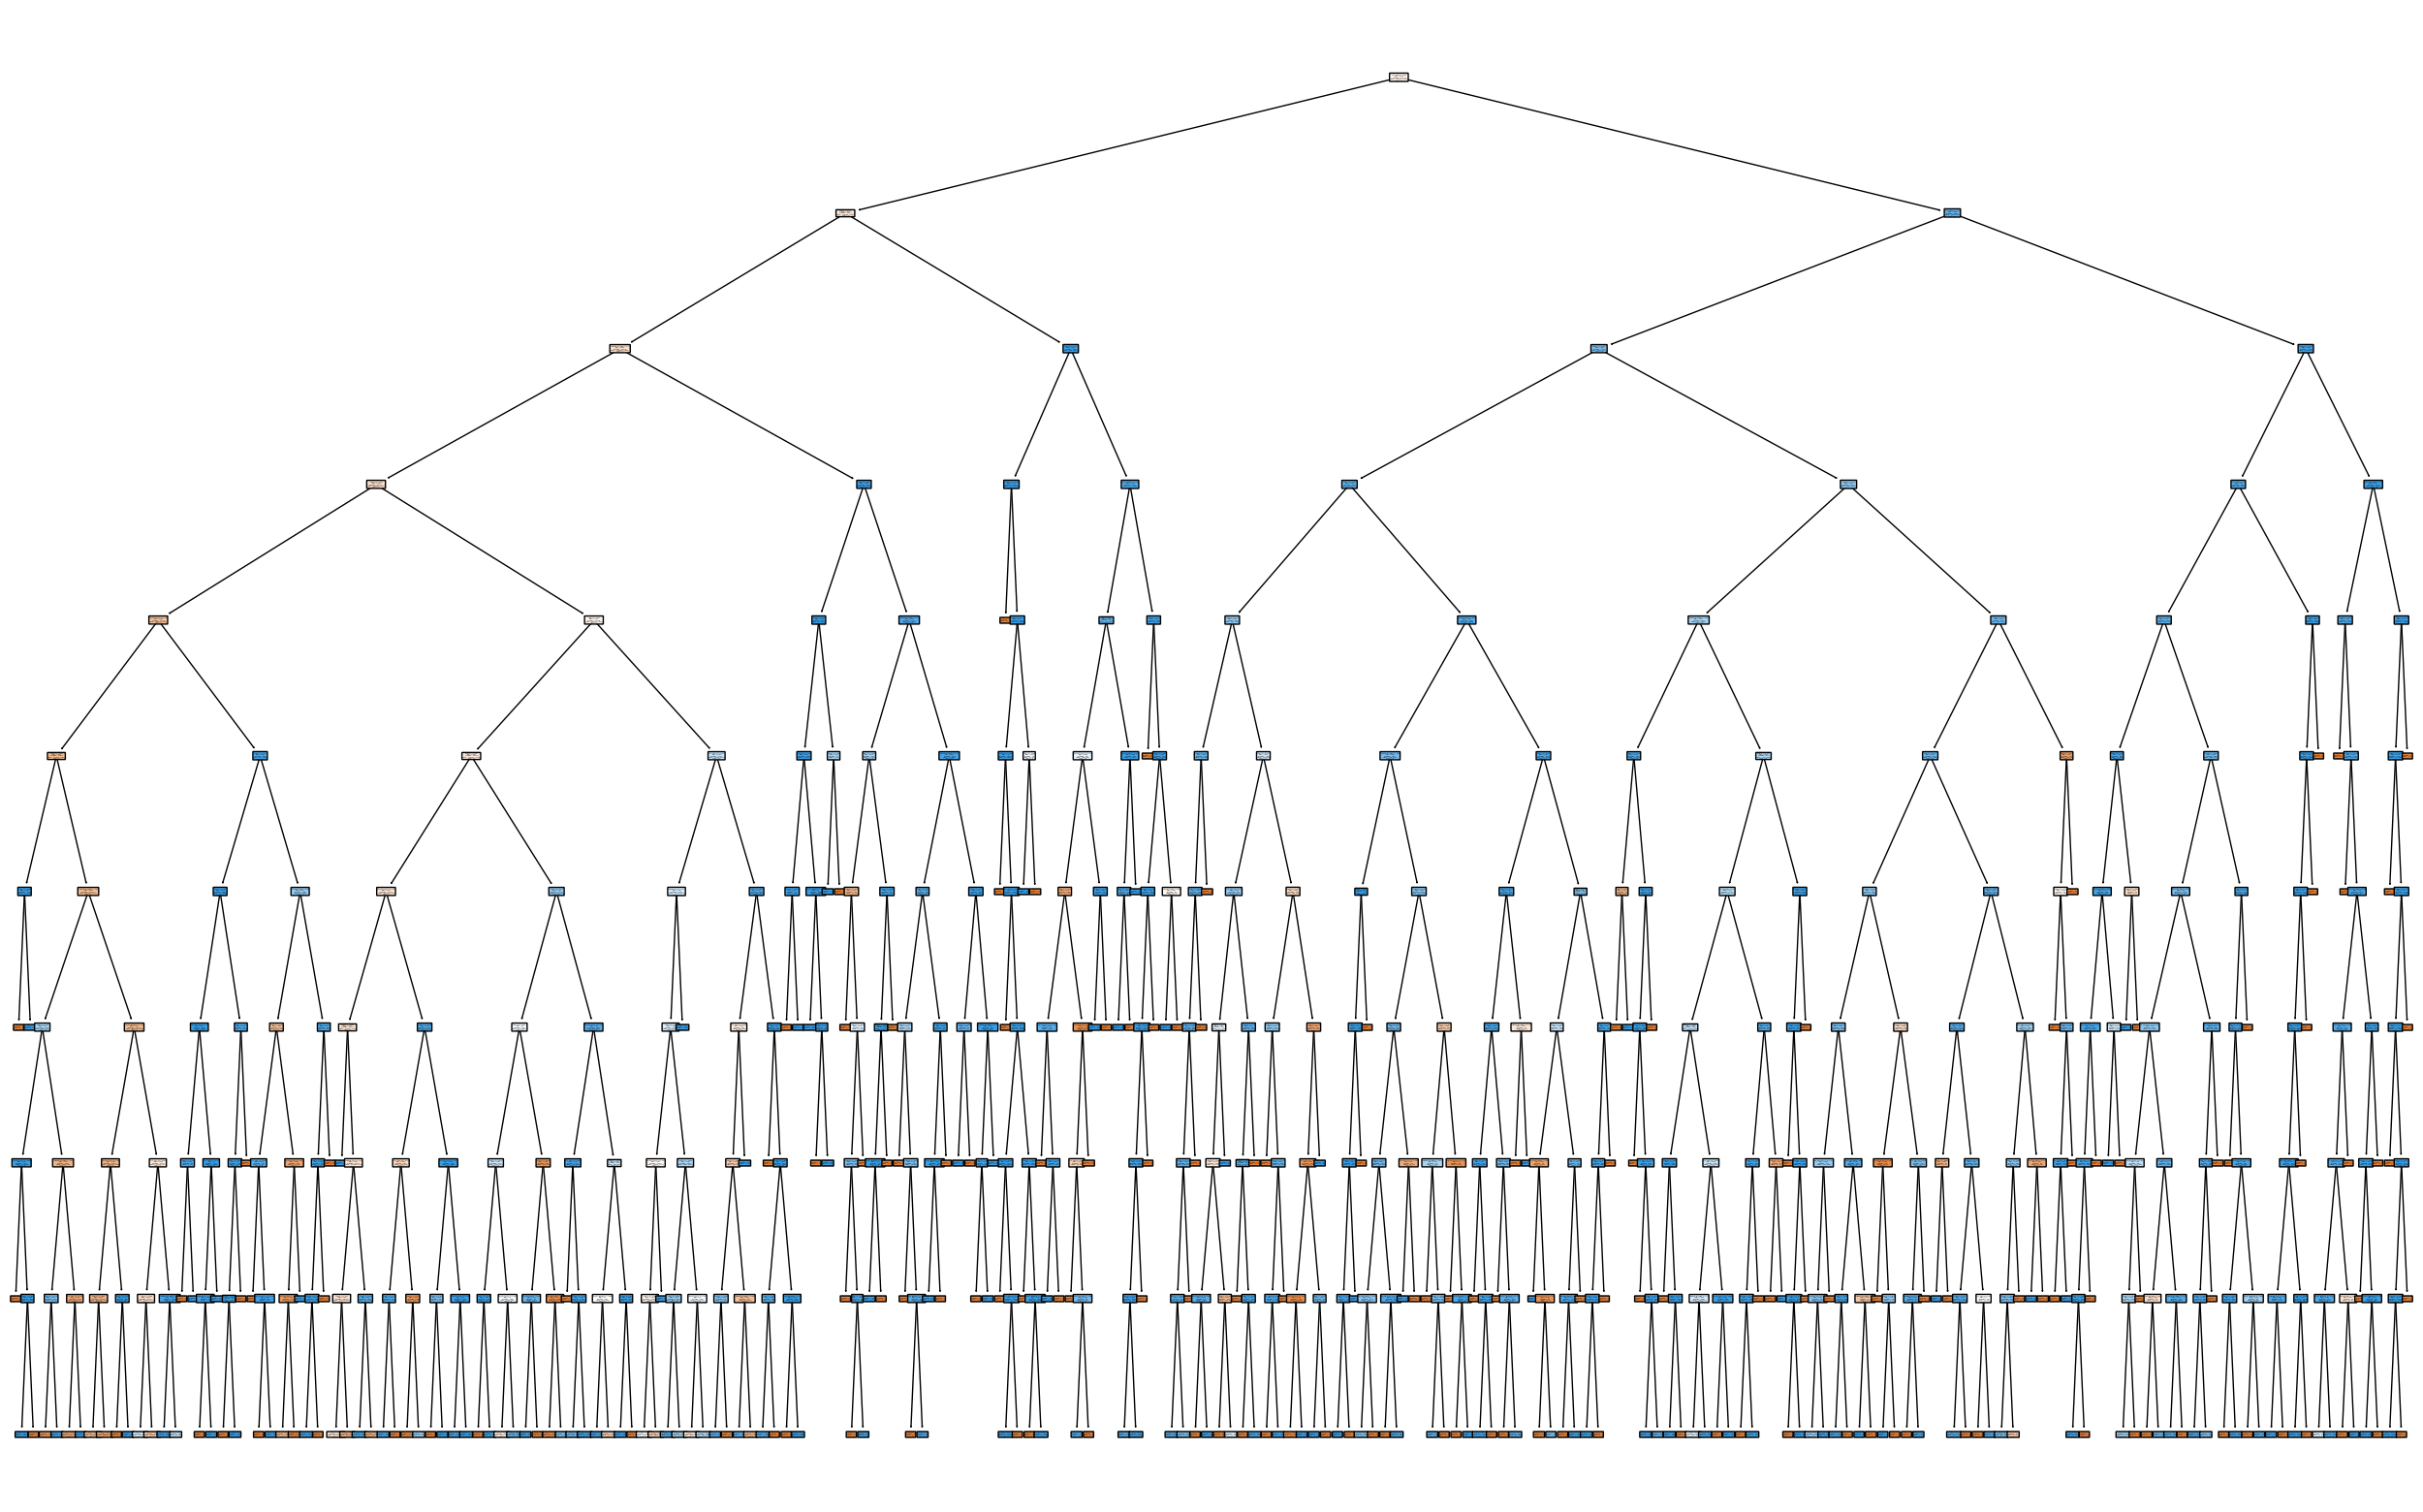

In [8]:
clf, max_depth = decision_tree_model(*ml_data.values(), run_name_="normal_run")
make_decision_tree(clf, max_depth, list(ml_data['x_train'].columns), ['ok', 'nok'])
#print_stats(clf, ml_data['x_test'], ml_data['y_test'])

<h4>Las losowy<h4>

In [ ]:
clf = random_forest_model(*ml_data.values(), run_name_="normal_run")

<h4>XGBoost</h4>

In [ ]:
clf = xgb_model(*ml_data.values(), run_name_="normal_run")

<h4>Sieci neuronowe<h4>

In [ ]:
compile_fit_evaluate_model(*ml_data_small.values(), epochs_=50, batch_size_=64, comment="standarized data", run_name_=f"small_data_100k")

<h4>Super drzewa losowe</h4>

In [ ]:
clf = extra_random_trees(*ml_data.values(), run_name_="first_run")

<h4>Cross Validacja</h4>

Według mnie na razie zostawmy cross validacje w spokoju, na normalnym zbiorze znajdzmy najlepsze parametry dla modeli a potem dopiero zrobmy na takich parametrach cross validacje by zobaczyc 'prawdziwa' jakosc modelu
PS. ponizszy kod wykonuje sie jakas 1h
PS2. dane sie zapisaly ale jakis syf

In [ ]:
artifact_directory="cv_random_forest"
mlflow.set_experiment(artifact_directory)
mlflow.sklearn.autolog()

with start_run(run_name="testowy run"):
    clf = RandomForestClassifier(random_state=0)
    scores = cross_val_score(estimator=clf, X=ml_data['x_train'], y=ml_data['y_train'], cv=5)
print(scores)
# [0.99786842 0.99779825 0.99742105 0.99770175 0.99797368] - wynik